In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import leakage
import reframed
import scipy
import cobra

# Bacillus

In [2]:
exometabolites_folder = Path("../../data/b_licheniformis/")
organism = 'b_licheniformis'
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [3]:
gDW_per_OD = 0.32

In [4]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, organism)

In [5]:
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD.fillna(df_OD['OD std'].mean())

,OD mean,OD std
Time,,
0,1.700,0.000000
1,1.745,0.007071
2,1.905,0.063640
3,2.080,0.042426
4,3.095,0.120208
5,4.235,0.007071
6,6.940,0.197990
7,9.735,0.035355
8,15.110,1.230366


# Max growth rate

Growth rate: 0.3767837508664997


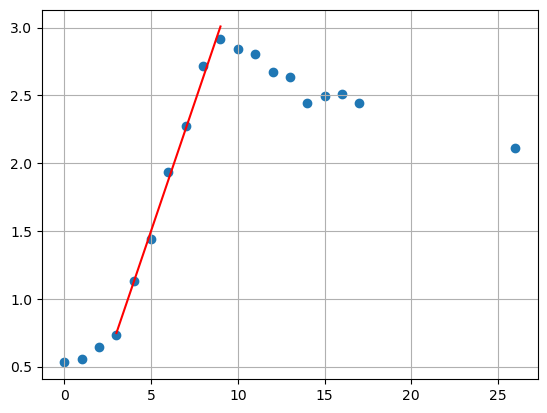

In [12]:
xarr = np.arange(3, 10, 1)
mu_fit = np.polyfit(df_OD.index[3:10], np.log(df_OD['OD mean'][3:10]), 1)
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.plot(xarr, mu_fit[0]*xarr+mu_fit[1], c = 'r')
plt.grid()
print(f'Growth rate: {mu_fit[0]}')

In [13]:
df_OD.index[3:10]

Int64Index([3, 4, 5, 6, 7, 8, 9], dtype='int64', name='Time')

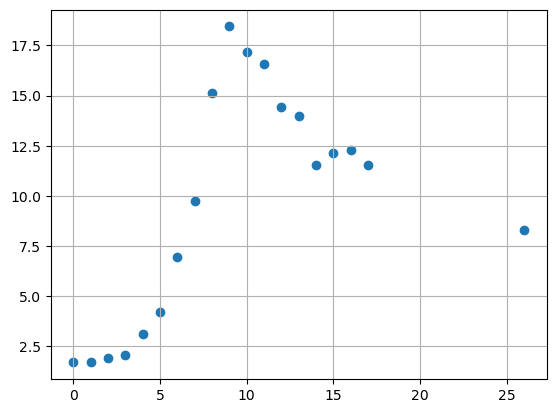

In [14]:
plt.scatter(df_OD.index, df_OD['OD mean'])
plt.grid()

# Estimate max glucose uptake rate
Answer = 5.3 mmol/gDW/h

In [15]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

df_glucose = pd.read_csv(fn_glucose, index_col=0)
# df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [16]:
cum_OD = np.zeros(19)*np.nan
for i in range(16):
    cum_OD[i+1] = scipy.integrate.simpson(df_OD.loc[1:i+1, 'OD mean'])

In [17]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*gDW_per_OD
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

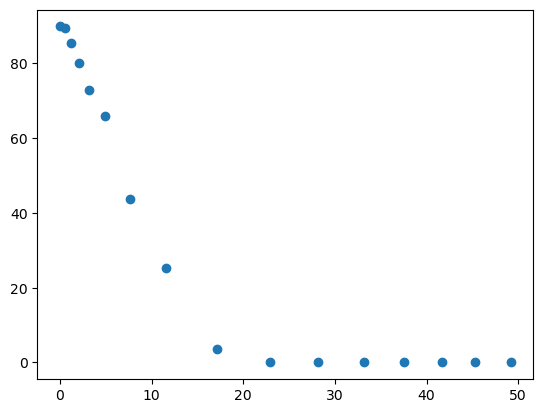

In [18]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [19]:
df_OD.loc[1:9, 'Cum OD gDW']

Time
1     0.000000
2     0.584000
3     1.220800
4     2.026400
5     3.214933
6     4.961200
7     7.666133
8    11.572533
9    17.118400
Name: Cum OD gDW, dtype: float64

In [21]:
fit = np.polyfit(df_OD.loc[1:9, 'Cum OD gDW'], df_glucose.loc[1:9, 'Glucose mM'], 1)
glucose_uptake = fit[0]
print(glucose_uptake)

-5.3175648105675775


## Mapping

In [14]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Bacillus metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Estimate rates

## Simpson integration

In [15]:
xt = np.zeros(len(df_OD)-1)
for i in range(1, len(df_OD)-1):
    xt[i] = scipy.integrate.simpson(df_OD.loc[:i, 'OD mean'].values, x = df_OD.index[:i+1])
    # xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
    print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

1 1.745 0.5512
2 1.905 1.1290666666666664
3 2.08 1.7662666666666667
4 3.095 2.549866666666666
5 4.235 3.7193333333333327
6 6.94 5.4272
7 9.735 8.0928
8 15.11 11.9328
9 18.44 17.355333333333334
10 17.18 23.2448
11 16.57 28.62746666666667
12 14.43 33.686400000000006
13 13.97 38.18560000000001
14 11.52 42.41493333333334
15 12.13 46.117333333333335
16 12.27 50.128
17 11.54 53.9608


In [16]:
x = xt*gDW_per_OD

In [17]:
# x = np.cumsum(df_OD['OD mean'])*gDW_per_OD

In [18]:
specific_limits = {
    'G6P': (1, 9),
    'F6P': (1, 9),
    'FBP': (2, 9),
    'DHAP': (1, 9),
    'GA3P': (1, 6),
    '23PG': (1, 9),
    'PEP': (1, 9),
    'R5P': (1, 9),
    'RU5P+X5P': (1, 9), 
    'E4P': (1, 9),
    'CIT': (1, 9),
    'ACN': (1, 9),
    'ICIT': (1, 9),
    'ASN': (2, 6),
    'GLU': (1, 6),
    'SER': (6, 7),
    'ASP': (1, 9),
    'GLN': (1, 6),
    'HOM': (1, 9),
    'TYR': (1, 9),
    'GLY': (1, 4),
    'PRO': (1, 6),
    'ALA': (1, 5),
    'MET': (1, 9),
    'VAL': (1, 9),
    'PHE': (1, 9),
    'LEU+ILEU': (1, 8),
    'TRP': (1, 9),
    'HIS': (1, 9),
    'LYS': (1, 9),
    'ARG': (1, 9),
    'PYR': (1, 8),
    'ORO': (1, 9),
    'FUM': (1, 8),
    'URA': (1, 9),
    'AKG': (1, 8),
    'SHI': (1, 9),
    'ACT': (1, 8),
}

In [19]:
concentrations['SER']

Time
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     0.232267
7     0.292667
8     0.258000
9     0.096000
10    0.140933
11    0.400667
12    0.762667
13    1.337333
14    1.613333
15    1.696000
16    1.733333
17    1.592000
26    1.537333
Name: SER, dtype: float64

R-squared: 0.989909
R-squared: 0.983935
R-squared: 0.052422
R-squared: 0.991700
R-squared: 0.984463
R-squared: 0.971296
R-squared: 0.986610
R-squared: 0.996685
R-squared: 0.997578
R-squared: 0.987798
R-squared: 0.996055
R-squared: 0.995516
R-squared: 0.980944
R-squared: 0.993863
R-squared: 0.963799
R-squared: 1.000000
R-squared: 0.976557
R-squared: 0.978433
R-squared: 0.968976
R-squared: 0.860540
R-squared: 0.997178
R-squared: 0.743403
R-squared: 0.808667
R-squared: 0.968494
R-squared: 0.885948
R-squared: 0.985042
R-squared: 0.746991
R-squared: 0.010875
R-squared: 0.813483
LYS More than 1 zero
R-squared: 0.000000
R-squared: 0.448313
R-squared: 0.973836
R-squared: 0.729803
R-squared: 0.928811
R-squared: 0.893839
AKG More than 1 zero
R-squared: 0.959379
R-squared: 0.879348
R-squared: 0.969221


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_87272/1590104171.py:45: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, y_max)


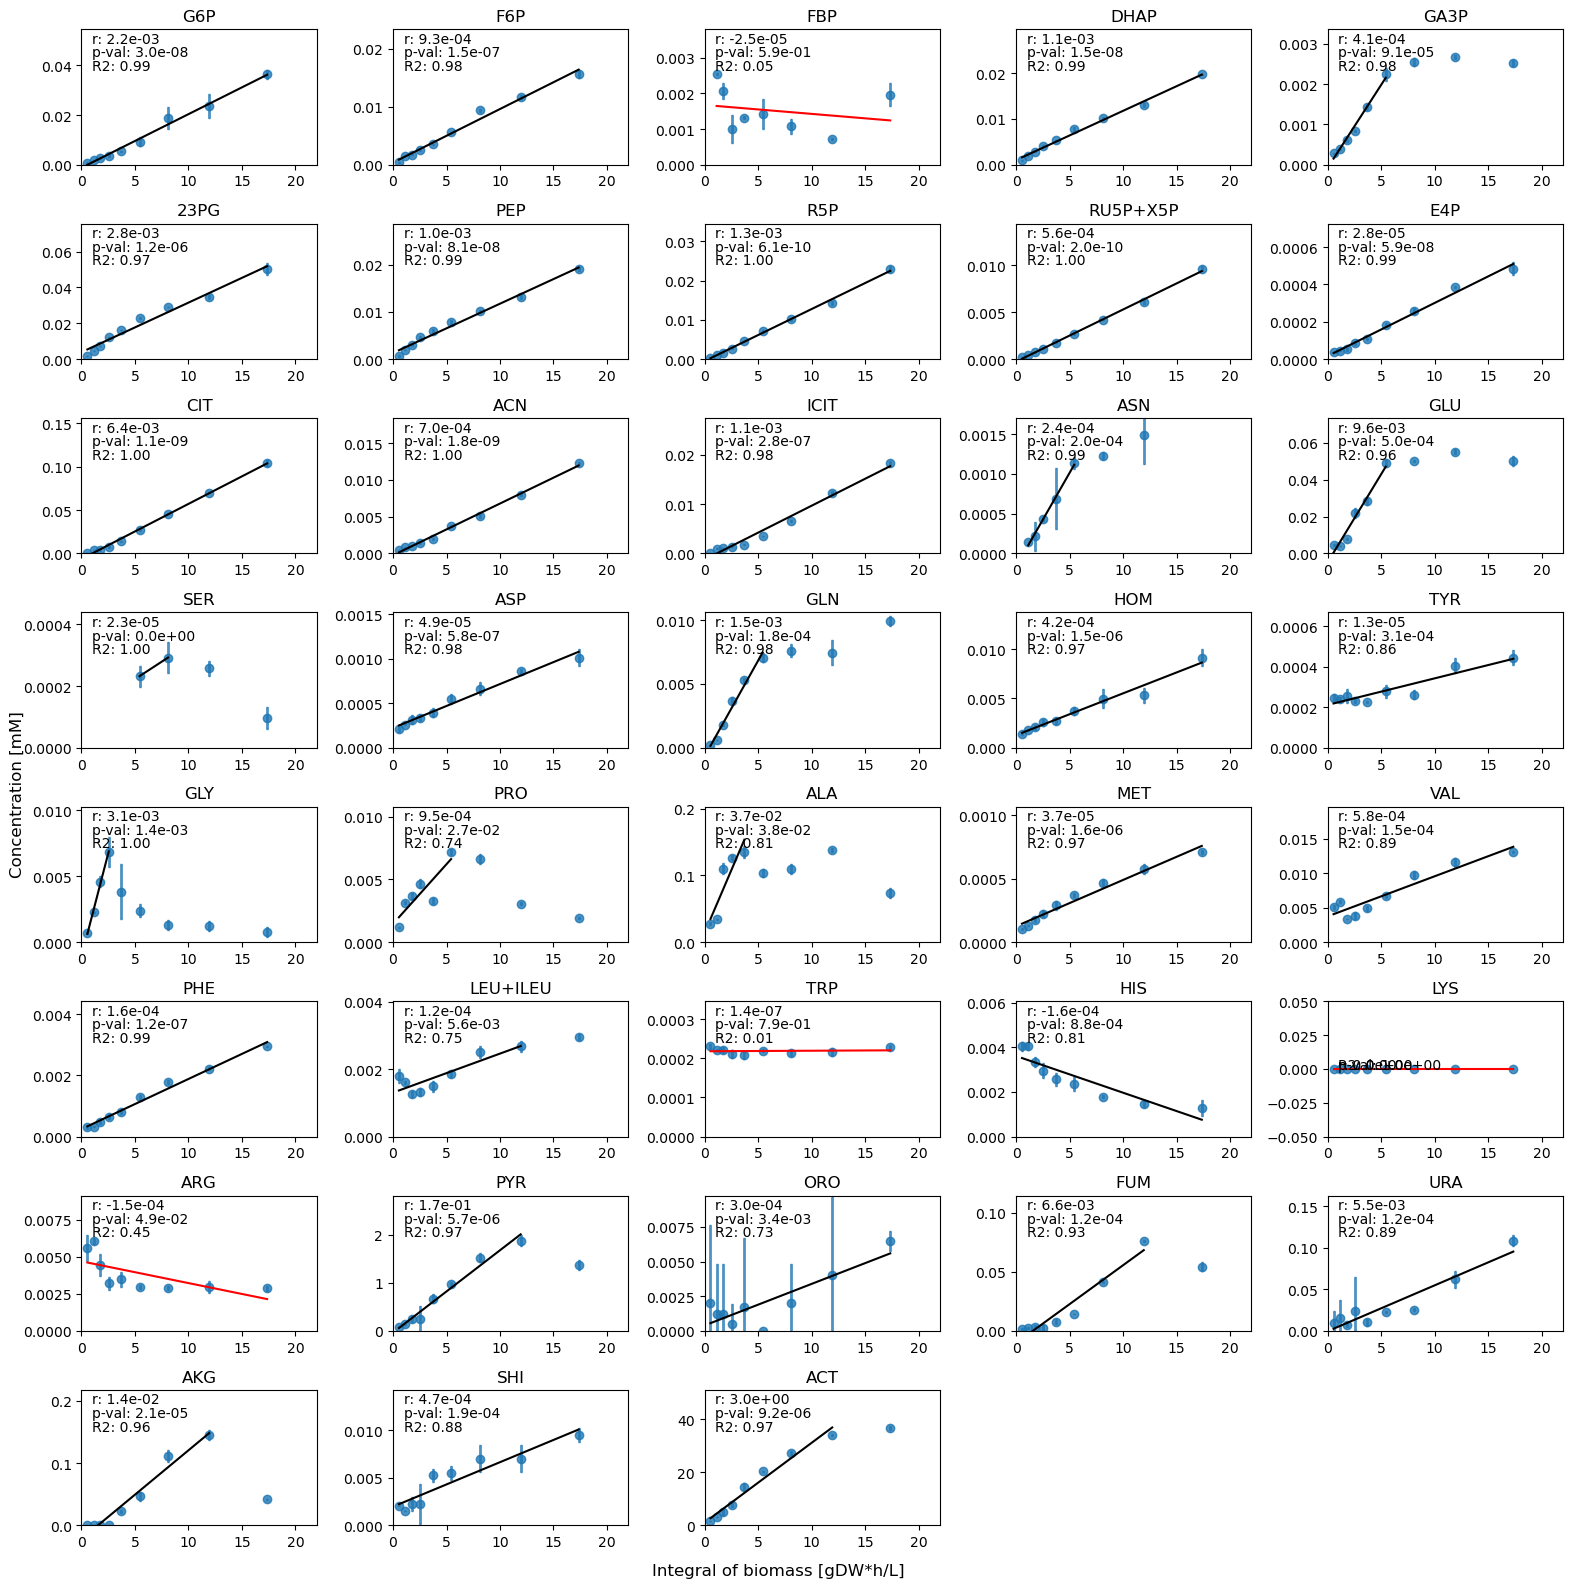

In [24]:
rate_dict_m = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
data_list = []
for i,c in enumerate(concentrations.columns):
    # print(c)
    conc = concentrations[c][:-1]*1e-3 # Convert from uM to mM #
    conc_std = concentrations_std[c][:-1]*1e-3
    lim = specific_limits[c]
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1]
    rate_conc = conc[idx]
    if np.sum(rate_conc == 0) > 1:
        print(c, 'More than 1 zero')
    # conc[conc==0] = np.nan
    res = scipy.stats.linregress(x[idx], conc[idx])
    print(f"R-squared: {res.rvalue**2:.6f}")
    r2 = res.rvalue**2
    
    # fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[idx],
    #                                            conc[idx], full_output=True)
    # rate = fit[0]
    # std_err = np.sqrt(np.diag(cov))[0]
    # t_score = fit[0]/std_err
    # n_df = np.sum(idx)-2
    # p_val = scipy.stats.t.sf(t_score, df = n_df)*2 # *2 is to get two-sided
    # data = [rate, std_err, t_score, n_df, p_val, c, p_val < 0.05]
    data = [res.slope, res.stderr,res.pvalue, c, res.pvalue < 0.05, r2]
    data_list.append(data)
    # rate_dict_m[c] = fit[0]
    # print(fit)
    x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
    y_fit = fun(x_fit, res.slope, res.intercept)
    ax = axes[i]
    # ax.scatter(x, conc)
    # ax.scatter(x, conc)
    ax.errorbar(x, conc, yerr = conc_std, fmt='o',color='C0',capthick=1,elinewidth=2,capsize=1, zorder = 0, alpha = 0.8)
    if r2 > 0.5:
        ax.plot(x_fit, y_fit, 'k')
    else:
        ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c, )
    ax.set_xlim(0, 22)
    y_max = np.max(conc[idx])*1.5
    ax.set_ylim(0, y_max)
    ax.annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
    ax.annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
    ax.annotate(f'R2: {r2:.2f}', (1, y_max*0.7))
    i +=1
    # print(i)

while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.savefig('blicheniformis_fitted_rates_manual_limits.png', dpi = 400)
plt.show()

In [25]:
rate_data = pd.DataFrame(data_list, columns = ['Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'p-val', 'Metabolite abbrv.', 'Significance', 'R2'])

In [26]:
# rate_dict = {}
# fig, axes = plt.subplots(8,5, figsize = (8, 12), sharex = True)
# axes = axes.flatten()
# fun = lambda x, a ,b: x*a+b
# max_idx = 9

# for i,c in enumerate(concentrations.columns):
#     conc = concentrations[c]*1e-3
#     conc[conc==0] = np.nan
#     nan_idx = ~np.isnan(conc)
#     time_idx = x.index <= max_idx
#     if np.sum(nan_idx&time_idx) == 1:
#         conc[0] = 0
#         nan_idx[0] = True
        
#     # print(conc[nan_idx&time_idx])
#     rate_conc = conc[nan_idx&time_idx]
#     selection = np.ones(len(conc)).astype(bool)
#     if (max_idx-1 in rate_conc.index) and (max_idx in rate_conc.index):
#         if rate_conc[max_idx] < rate_conc[max_idx-1]:
#             selection[max_idx] = False
#             if rate_conc[max_idx-1] < rate_conc[max_idx-2]:
#                 selection[max_idx-1] = False
#     # print(c)
#     # print(conc[nan_idx&time_idx])
#     if c in ['GA3P', 'GLU', 'GLN']:
#         selection[max_idx] = False
#         selection[max_idx-1] = False
#     elif c in ['ACT']:
#         selection[max_idx] = False
#     elif c in ['GLY', 'ALA']:
#         selection[5:] = False
        
#     if len(conc[nan_idx&time_idx&selection]) >1:
#         fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[nan_idx&time_idx&selection],
#                                                    conc[nan_idx&time_idx&selection],
#                                                    full_output=True)
#         rate_dict[c] = fit[0]
#     else:
#         rate_dict[c] = np.nan

#     # print(fit)
#     x_fit = np.linspace(0, x[nan_idx&time_idx].max(), 3)
#     y_fit = fun(x_fit, *fit)
#     ax = axes[i]
#     # ax.scatter(x, conc)
#     ax.scatter(x[nan_idx&time_idx], conc[nan_idx&time_idx])
#     ax.plot(x_fit, y_fit, 'r')
#     ax.set_title(c)

# i +=1
# # print(i)
# while i<(8*5):
#     axes[i].set_visible(False)
#     i+=1

# fig.supxlabel('Integral of biomass [gDW*h/L]')
# fig.supylabel('Concentration [mM]')

# plt.tight_layout()
# plt.show()


# Get model

In [27]:
# Couldn't get this model to work with reframed 
model_fn = '../../models/b_licheniformis/iBsu1147_irr_enz_constraint_adj.xml'
model_ez = cobra.io.read_sbml_model(model_fn)
# model = cobra.io.load_matlab_model('../../models/{0}/ec_iYO844.mat'.format(species))

model_ez.solver = 'gurobi'

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19


In [84]:
model_ez.reactions.EX_glc__D_e.lower_bound = glucose_uptake
solution = model_ez.optimize()

In [85]:
print(model_ez.summary())

Objective
1.0 bio00006 = 0.3992822627938095

Uptake
------
Metabolite    Reaction     Flux  C-Number  C-Flux
     ca2_e    EX_ca2_e 0.001191         0   0.00%
     fe3_e    EX_fe3_e 0.001281         0   0.00%
  glc__D_e EX_glc__D_e    5.318         6 100.00%
       k_e      EX_k_e   0.2626         0   0.00%
     mg2_e    EX_mg2_e  0.03783         0   0.00%
     nh4_e    EX_nh4_e      3.6         0   0.00%
      o2_e     EX_o2_e    15.18         0   0.00%
      pi_e     EX_pi_e   0.4076         0   0.00%
     so4_e    EX_so4_e  0.07912         0   0.00%
 prot_pool enzyme_pool    0.165         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -16.18         1 100.00%
     h2o_e EX_h2o_e -25.13         0   0.00%
       h_e   EX_h_e -2.993         0   0.00%



In [32]:
measured_metabolites = []
for bigg_id in met_abrv_to_id.values():
    if not isinstance(bigg_id, str):
        continue
    m_ids = bigg_id.split(', ')
    for m_id in m_ids:
        if f'{m_id}_c' in model_ez.metabolites:
            measured_metabolites.append(f'{m_id}_c')

# Shadow prices

In [63]:
with model_ez as model:
    model.reactions.EX_glc__D_e.lower_bound = glucose_uptake
    shadow_prices = leakage.estimate_shadow_prices(model, delta=0.01, metabolites = measured_metabolites)

In [112]:
glc_uptake_range = np.linspace(glucose_uptake*1.2, glucose_uptake*0.8, 5, endpoint=True)

shadow_price_list = []
with model_ez as model:
    for g in glc_uptake_range:   
        model.reactions.EX_glc__D_e.lower_bound = g
    shadow_prices_i = leakage.estimate_shadow_prices(model, delta=0.01, metabolites = measured_metabolites)
    shadow_price_list.append(shadow_prices_i)
shadow_price_list.append(shadow_prices)

In [114]:
df_sp_var = pd.DataFrame(shadow_price_list)

# Turnover

In [115]:
with model_ez as model:
    model.reactions.EX_glc__D_e.lower_bound = -5.3
    solution = cobra.flux_analysis.pfba(model)
turnover = {}
for m_id in measured_metabolites:
    m = model_ez.metabolites.get_by_id(m_id)
    turnover[m_id] = m.summary(solution).producing_flux['flux'].sum()

    

# Make spreadsheet

In [116]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The D-forms are used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std.Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std.Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'{bigg_id}_c'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites.get_by_id(m_id)
        Nc = m.elements['C']
        mass = m.formula_weight
        mv_min = -df_sp_var.max()[m_id]
        mv_max = -df_sp_var.min()[m_id]
        
        data.append([abbr, bigg_id, name, mv, mv_min, mv_max, turnover[m_id], Nc, mass, rate_i, std_err_i, row['R2']])
df_rate = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'BiGG ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]','MV min', 'MV max', 
                                        'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'R2'])
        


['2pg', '3pg']
['ru5p__D', 'xu5p__D']
['leu__L', 'ile__L']


In [117]:
# data = []
# for abbr, rate in rate_dict.items():
#     bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',')]
#     rate = rate/len(bigg_ids)
#     for bigg_id in bigg_ids:
#         name =met_abrv_to_name[abbr]
#         m_id = f'{bigg_id}_c'
#         mv = -shadow_prices[m_id]
#         m = model_ez.metabolites.get_by_id(m_id)
#         Nc = m.elements['C']
#         mass = m.formula_weight
        
#         data.append([bigg_id, name, rate, mv, turnover[m_id], Nc, mass])
# df_rate = pd.DataFrame(data, columns = ['BiGG ID', 'Metabolite', 'Rate [mmol/gDW/h]', 
#                                         'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
#                                         'Mol weight [g/mol]'])

In [118]:
df_rate['Species'] = 'B. licheniformis'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [119]:
df_rate.to_csv('paczia_13_rates_blicheniformis_0824.csv')

# No enzyme constraint

In [54]:
model0 = model_ez.copy()

Read LP format model from file /var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/tmp54stm5b7.lp
Reading time = 0.01 seconds
: 1460 rows, 6592 columns, 32868 nonzeros


In [55]:
model0.reactions.enzyme_pool.upper_bound = 1000

In [56]:
model0.optimize()
print(model0.summary())

Objective
1.0 bio00006 = 0.39502688752416626

Uptake
------
Metabolite    Reaction     Flux  C-Number  C-Flux
     ca2_e    EX_ca2_e 0.001178         0   0.00%
     fe3_e    EX_fe3_e 0.001268         0   0.00%
  glc__D_e EX_glc__D_e        5         6 100.00%
       k_e      EX_k_e   0.2598         0   0.00%
     mg2_e    EX_mg2_e  0.03742         0   0.00%
     nh4_e    EX_nh4_e    3.562         0   0.00%
      o2_e     EX_o2_e    13.46         0   0.00%
      pi_e     EX_pi_e   0.4033         0   0.00%
     so4_e    EX_so4_e  0.07828         0   0.00%
 prot_pool enzyme_pool   0.3507         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -14.44         1 100.00%
     h2o_e EX_h2o_e -23.29         0   0.00%
       h_e   EX_h_e -2.961         0   0.00%



In [58]:
with model0 as model:
    model.reactions.EX_glc__D_e.lower_bound = -5.3
    shadow_prices0 = leakage.estimate_shadow_prices(model, delta=0.01, metabolites = measured_metabolites)

## Make spreadsheet

In [60]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The D-forms are used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std.Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std.Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'{bigg_id}_c'
        mv = -shadow_prices0[m_id]
        m = model_ez.metabolites.get_by_id(m_id)
        Nc = m.elements['C']
        mass = m.formula_weight
        
        data.append([abbr, bigg_id, name, mv, Nc, mass, rate_i, std_err_i, row['R2']])
df_rate0 = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'BiGG ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'R2'])

['2pg', '3pg']
['ru5p__D', 'xu5p__D']
['leu__L', 'ile__L']


In [61]:
df_rate0['Species'] = 'B. licheniformis'
df_rate0['Carbon source'] = 'Glucose'
df_rate0['Dataset'] = 'Paczia-13'
df_rate0.to_csv('paczia_13_rates_blicheniformis_0824_no_enz.csv')